# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

%matplotlib inline

RESPONSE_VAR = 'temperature'
WINDOW_SIZE = 7
CONV_WIDTH = 3

In [58]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


In [59]:
df.shape

(45253, 6)

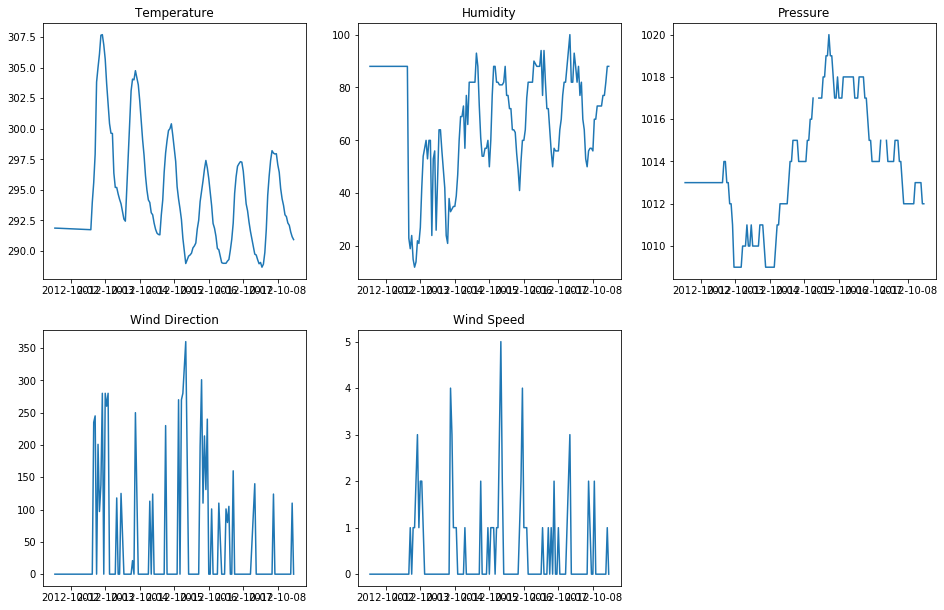

In [60]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [61]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [62]:
252 / df.shape[0]

0.0055686915784588864

In [63]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Feature Engineering

In [64]:
# Source: https://www.tensorflow.org/tutorials/structured_data/time_series

wv = df.pop('wind_s')
# Convert to radians.
wd_rad = df.pop('wind_d')*np.pi / 180

# Calculate the wind x and y components.
df['wind_x'] = wv*np.cos(wd_rad)
df['wind_y'] = wv*np.sin(wd_rad)

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [65]:
# Convert date col to numeric representation.

datetimes = df['datetime']

df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)
# # Create copy of Dataframe for Noisy dataset creation.
# noisy_test_df = test_df.copy()



In [66]:
noise_level = 0.2

In [67]:
def create_noisy_df(reference_df, noise_level=noise_level):
    """Create a Dataframe with artificially inserted gaps (in form of NaN) from a 'complete'
    Reference dataframe.
    
    Args:
        reference_df (pd.Dataframe): Complete Dataframe
        noise_level (float): Percentage of Dataframe containing NaN.
        
    Returns:
        noisy_df (pd.Dataframe): Dataframe containing NaN values.
    """
    # generate a range of vals (0 ... n_rows)
    idxs = np.arange(reference_df.shape[0])
    # generate a sin wave onto range
    noisy_df_sin = np.sin(idxs) ** 2
    # use sum as denominator to make the sin vals total to 1.
    sum_idxs = np.sum(noisy_df_sin)

    prob = noisy_df_sin / sum_idxs
    # check the sum of sin's totals to 1.
    assert int(np.sum(prob)) == 1

    n_gaps = int(reference_df.shape[0] * noise_level)
    # randomly choose gap indexes
    gap_indxs = np.random.choice(a=test_df.shape[0], size=n_gaps, replace=False, p=prob)
    
    noisy_df = reference_df.copy()

    noisy_df['temperature'].iloc[gap_indxs] = np.nan
    
    return noisy_df
    

In [68]:
sample_size = 100

In [69]:
def plot_noisy_series(complete_series, noisy_series, 
                      noise_level=noise_level, sample_size=100):
    '''
        Inputs:
            complete_series: Series containing all values.
            noisy_series: Series containing missing values due to artifical noise.
            noise_level: Amount of noise imposed on Series(for plotting).
    '''
    
    
    # extract datetimes for df indexing
    test_datetimes =  datetimes[-test_df.shape[0]:]
    # Create df for easy plotting
    df_temp_all = pd.DataFrame({'Complete': complete_series,
                                'Noisy': noisy_series}).set_index(test_datetimes)

    # Create a indicator column for missing temperature value.
    df_temp_all['Missing'] = df_temp_all[df_temp_all['Noisy'].isna()]['Complete']
    
    styles=['k--', 'bo-', 'r*']
    
    start_index = np.random.randint(low=0, high=df_temp_all.shape[0]-sample_size)
    end_index = start_index + sample_size
    
    df_temp_all.iloc[start_index:end_index, :].plot(style=styles, figsize=(20,10));
    plt.title(f'Missing Temperature Values at Noise Level: {noise_level}')
    plt.ylabel('Temperature');

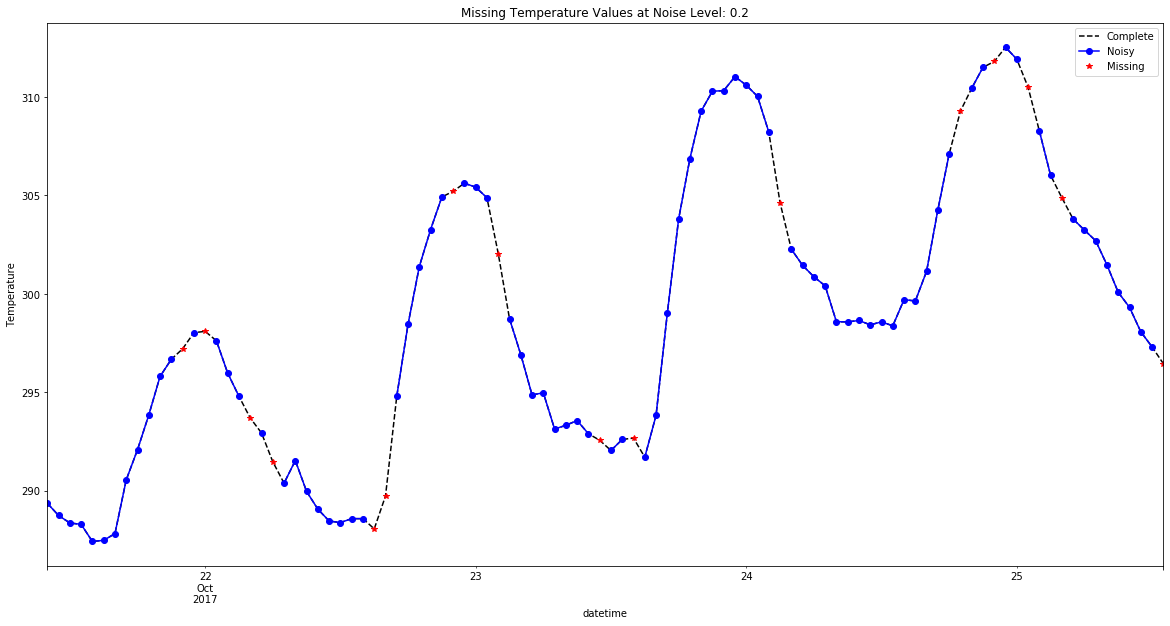

In [70]:
noisy_test_df = create_noisy_df(test_df, noise_level=noise_level)

plot_noisy_series(test_df['temperature'], noisy_test_df[RESPONSE_VAR])

#### Benchmarking Conventional Methods

In [71]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

def benchmark_conventional_methods(noisy_df, methods):
    mses = []

    for method in methods:
        order = 2
        temp_int = noisy_df['temperature'].interpolate(method=method, order=order)
        # fill if method creates NA val
        temp_int = temp_int.fillna(method='bfill').fillna(method='ffill')
        mse = mean_squared_error(test_df['temperature'], temp_int)

        mses.append(mse)
        
    return pd.DataFrame({
        "method": methods,
        "MSE": mses}).sort_values(by='MSE',
                                  ascending=True).set_index(['method'])

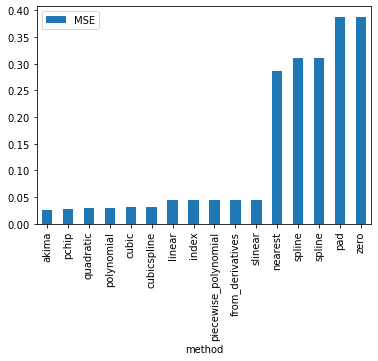

In [72]:
methods_df = benchmark_conventional_methods(noisy_test_df, methods)

methods_df.plot(kind='bar')

## Linear Model

In [232]:
train_df, val_df, test_df = split_df(df)
train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, dependent=RESPONSE_VAR)

#### Windowing data

In [74]:
single_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

# window

In [75]:
single_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [76]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, single_window)

# Clear output from Ipython display after compiling.
clear_output()

### Convert Predictions into Interpolation Function
- find nans indexes 
- get preceeding 7 indexes for nan indexes, if index < 7 => interpolate with conventional method
- feed 7 size window to model
- merge prediction into noisy dataframe

In [211]:
#################### COPY


def model_interpolate(model, window, noisy_test_df, window_size=WINDOW_SIZE, 
                      conv_model=False, gap_size=1):
    """Interpolate a noisy column using a Tensorflow model predictions.
    
    Args:
        model: Tensorflow model.
        window: Window object.
        noisy_test_df (pd.Dataframe): Dataframe containing noise (NaN)
        window_size: if `conv_model=False`, size of input_window
        conv_model (bool): Type of model and window.
        
    Returns:
        noisy_test_array (np.array): A numpy array containing original data 
            and interpolated predictions.
    """
    
    noisy_test_df_copy = noisy_test_df.copy()
    # Interpolate the first n-window-size to enable further interpolation.
    noisy_test_df_copy.iloc[:window.total_window_size] = noisy_test_df_copy.iloc[:window.total_window_size].interpolate(method='akima')
    noisy_test_array = noisy_test_df_copy[RESPONSE_VAR].to_numpy()
    
    # Get indexes of nan values, index to 0th dimension (ugly)
    nan_indxs = np.where(np.isnan(noisy_test_array))[0]
    
    count=0
    for nan_indx in nan_indxs:        
        window_instance = window.make_dataset(window.test_df[nan_indx - window.total_window_size: nan_indx])
        
        # Make a prediction for the NaN
        preds = model.predict(window_instance)
        
        last_pred_index = window.label_width - 1
        # Extr
        pred = preds[0,last_pred_index,0]

        # Interpolate point inplace of the NaN index.
        np.put(noisy_test_array, nan_indx, pred)
        
    return noisy_test_array



#### Tensorflow Linear Model Interpolation

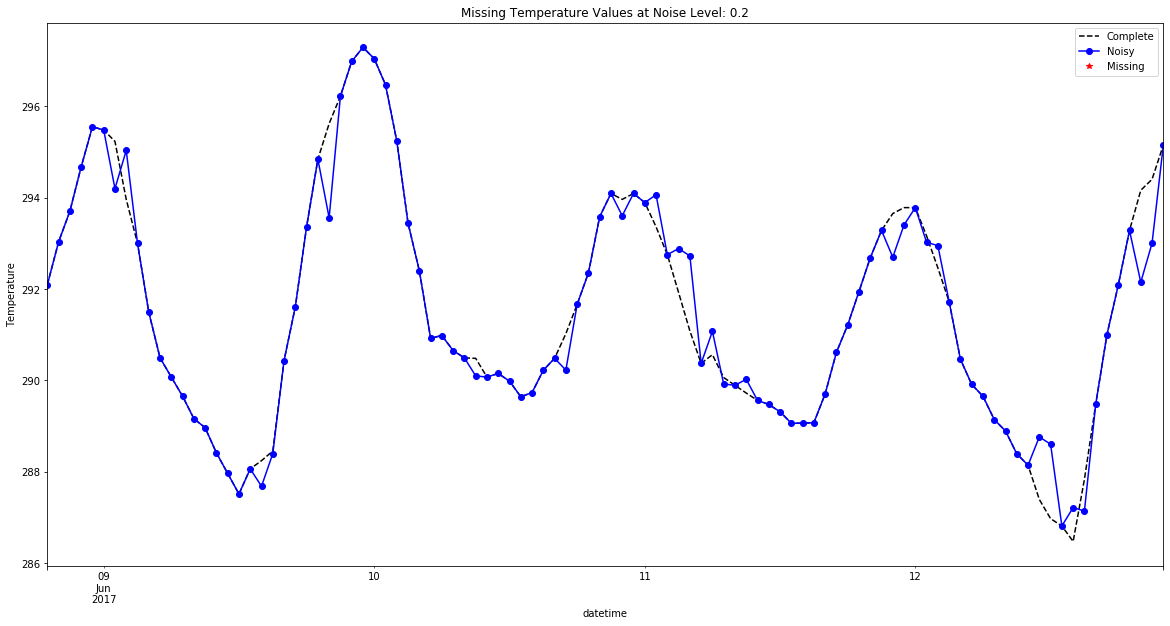

In [238]:
interp_linear = model_interpolate(linear, single_window, noisy_test_df)

plot_noisy_series(test_df[RESPONSE_VAR], interp_linear)

In [239]:
def score_interpolation(interpolated_array, test_array, metric=mean_squared_error):
    return metric(test_array, interpolated_array) 

In [240]:
score_interpolation(interp_linear, test_df[RESPONSE_VAR])

0.9091922393044866

#### Convolutional Model

In [233]:
CONV_WINDOW_SIZE = WINDOW_SIZE - 2

# conv_model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(filters=64,
#                            kernel_size=(CONV_WIDTH,),
#                            activation='relu'),
#     tf.keras.layers.GRU(32, return_sequences=True),
#     tf.keras.layers.GRU(32, return_sequences=True),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))

# ])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


conv_window = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=CONV_WINDOW_SIZE, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

compile_and_fit(conv_model, conv_window)
clear_output()

#### Convolutional Interpolation

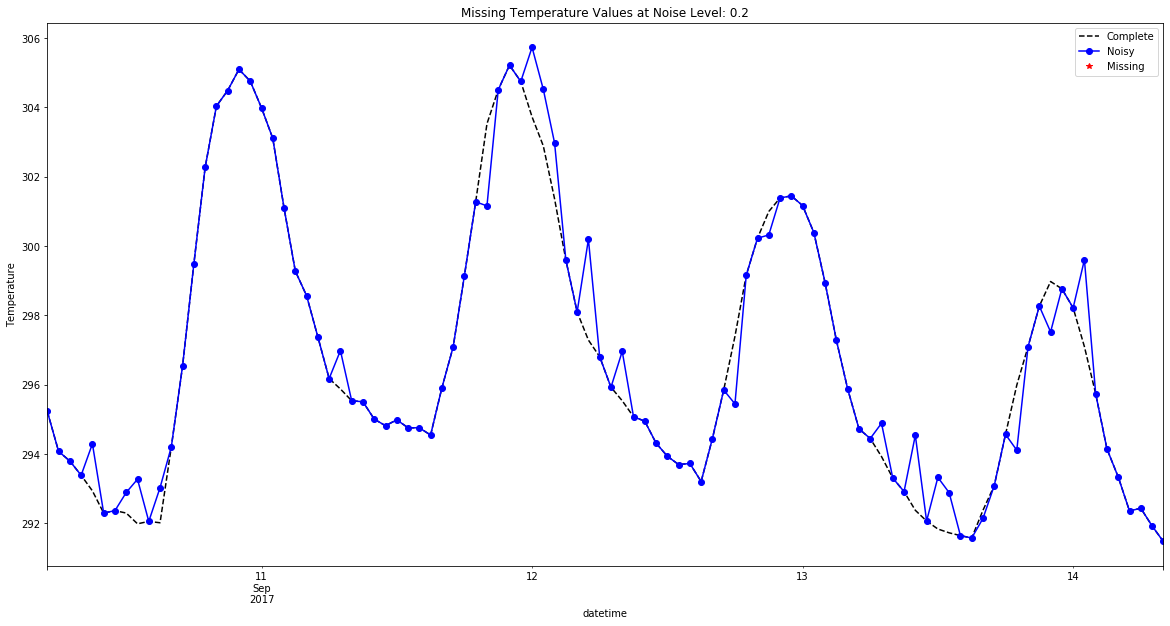

In [235]:
interp_conv = model_interpolate(conv_model, conv_window, noisy_test_df)

plot_noisy_series(test_df[RESPONSE_VAR], interp_conv)

In [237]:
score_interpolation(interp_conv, test_df['temperature'])

0.8059800344191893

### Train Test Split
* Q: How to compare to conventional methods
* Q: How to split within dataframe, opposed to splitting off the last 20%?

What I'm thinking...



### Make the Noise Longer

We can see the ML methods are performing terribly when compared to the conventional methods. This makes sense, as we can see that often the gaps in the data are quite linear in nature. To challenge the conventional methods more, we can create a noisy dataset, with larger intervals of ```NaN``` values.

###### Method
* Generate consecutive gaps in data ranging from 24-36 values in length (1-1.5 days)

In [104]:
noise_level = 0.2
gap_size = 36


n_nans = int(noise_level * test_df.shape[0])
n_nans

n_gap_sequences = int(n_nans / gap_size)

In [105]:
# random consecutive choice of values of size, `gap_size` with `replacement=False`

In [106]:
def generate_gap_sequences_indices(n_gap_sequences, gap_size):
    """TODO: n_nans != sum of NaN in df.
    """
    gap_indices = []
    count = 0

    while (count < n_gap_sequences):
        # Generate a random slice indicies
        start_index = np.random.randint(low=0, high=test_df.shape[0] - gap_size)
        end_index = start_index + gap_size

        # If index in current gap indices, ignore to avoid longer sequences
        if start_index in gap_indices: 
            continue

        else:
            count += 1
            
            gap_i_range = list(np.arange(start_index, end_index))
            gap_indices.extend(gap_i_range)
            
    return gap_indices, count

In [107]:
gap_indices, c = generate_gap_sequences_indices(n_gap_sequences, gap_size)
noisy2_test_df = test_df.copy()

noisy2_test_df['temperature'].iloc[gap_indices] = np.nan

In [108]:
methods_noise2_df = benchmark_conventional_methods(noisy2_test_df, methods)

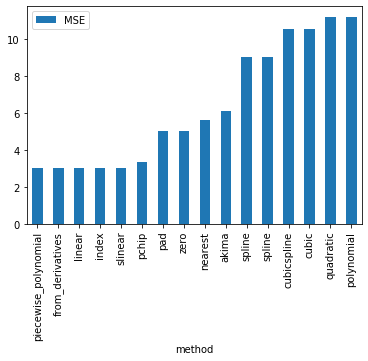

In [109]:
methods_noise2_df.plot(kind='bar')

In [110]:
def plot_noisy_series(complete_series, noisy_series, 
                      noise_level=noise_level, sample_size=100):
    '''
        Inputs:
            complete_series: Series containing all values.
            noisy_series: Series containing missing values due to artifical noise.
            noise_level: Amount of noise imposed on Series(for plotting).
    '''
    
    
    # extract datetimes for df indexing
    test_datetimes =  datetimes[-test_df.shape[0]:]
    # Create df for easy plotting
    df_temp_all = pd.DataFrame({'Complete': complete_series,
                                'Noisy': noisy_series}).set_index(test_datetimes)

    # Create a indicator column for missing temperature value.
    df_temp_all['Missing'] = df_temp_all[df_temp_all['Noisy'].isna()]['Complete']
    
    styles=['k--', 'bo-', 'r*']
    
    start_index = np.random.randint(low=0, high=df_temp_all.shape[0]-sample_size)
    end_index = start_index + sample_size
    
    df_temp_all.iloc[start_index:end_index, :].plot(style=styles, figsize=(20,10));
    plt.title(f'Missing Temperature Values at Noise Level: {noise_level}')
    plt.ylabel('Temperature');
    
#     return df_temp_all

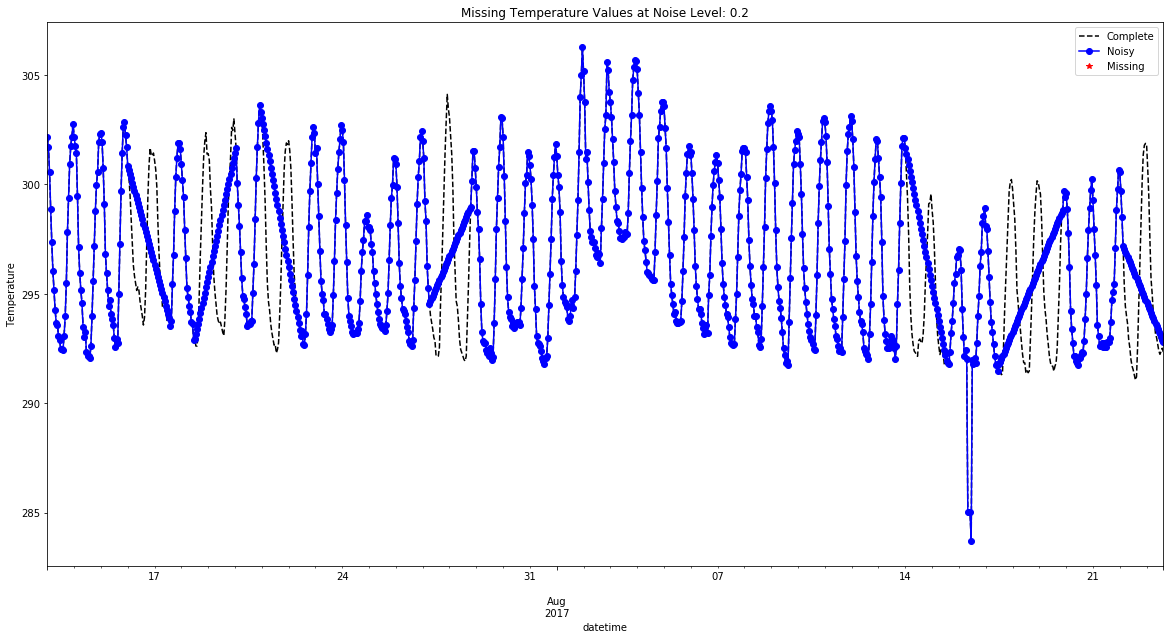

In [111]:
con_linear_interp = noisy2_test_df.interpolate(method='linear')

plot_noisy_series(test_df['temperature'], con_linear_interp[RESPONSE_VAR], sample_size=1000)

In [98]:
mean_squared_error(con_linear_interp, test_df)

0.4722053989495908

#### Convolutional Model for Noise 2.

So input_width >= label_width??



In [13]:
CONV_WINDOW_SIZE = gap_size 

conv_window2 = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=gap_size, shift=gap_size,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

print(conv_window2)

print(conv_window2.input_width, conv_window2.label_width)

compile_and_fit(textbook_model, conv_window2)
clear_output()

Total window size: 74
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Label indices: [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73]
Label column name(s): ['temperature']
38 36


NameError: name 'textbook_model' is not defined

In [66]:
def model_interpolate(model, window, noisy_test_df, window_size=WINDOW_SIZE, 
                      conv_model=False, gap_size=1):
    """Interpolate a noisy column using a Tensorflow model predictions.
    
    Args:
        model: Tensorflow model.
        window: Window object.
        noisy_test_df (pd.Dataframe): Dataframe containing noise (NaN)
        window_size: if `conv_model=False`, size of input_window
        conv_model (bool): Type of model and window.
        
    Returns:
        noisy_test_array (np.array): A numpy array containing original data 
            and interpolated predictions.
    """
    
    noisy_test_df_copy = noisy_test_df.copy()
    # Interpolate the first n-window-size to enable further interpolation.
    noisy_test_df_copy.iloc[:window.input_width] = noisy_test_df_copy.iloc[:window.input_width].interpolate(method='akima')
    noisy_test_array = noisy_test_df_copy[RESPONSE_VAR].to_numpy()
    
    # Get indexes of nan values, index to 0th dimension (ugly)
    nan_indexs = np.where(np.isnan(noisy_test_array))[0]

    for nan_index in nan_indexs:
        if conv_model:
            start_index = nan_index - window.input_width
            window_instance = window.test_df[
                                            start_index:
                                            window.input_width + (start_index)]
            
#             print(window_instance)
            
            window_instance = window.make_dataset(window_instance)
        else:
            window_instance = window.test_df[nan_index - window_size: nan_index]
    
        # Make a prediction for the NaN
        print(window_instance)
        
        preds = model.predict(window_instance)
        # Insert the pred inplace of the NaN
        
        if gap_size > 1:
            interp_indices = np.arange(nan_index, nan_index + gap_size)
            interp_vals = preds[0].flatten()
        else:
            interp_indices = nan_index
            interp_vals = preds[-1]
        
        np.put(noisy_test_array, interp_indices, interp_vals)
        nan_indexs = np.where(np.isnan(noisy_test_array))[0]
        
    return noisy_test_array

interp_textbook = model_interpolate(model=textbook_model,
                                    window=conv_window2,
                                    noisy_test_df=noisy2_test_df,
                                    conv_model=True,
                                    gap_size=gap_size)

<MapDataset shapes: ((None, 38, 7), (None, 36, 1)), types: (tf.float32, tf.float32)>


ValueError: Expect x to be a non-empty array or dataset.

In [16]:
gap_size = 36

NameError: name 'single_window' is not defined

In [51]:
OUT_STEPS = gap_size

num_features = df.shape[1]

multi_window = WindowGenerator(input_width=gap_size,
                               label_width=10,
                               shift=gap_size,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df)

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


compile_and_fit(multi_dense_model, multi_window)

clear_output()

Epoch 1/20


ValueError: in user code:

    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:797 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1215 mean_squared_error
        return backend.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10423 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3565 _create_op_internal
        op_def=op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 36 and 10 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_3/reshape_3/Reshape, IteratorGetNext:1)' with input shapes: [?,36,7], [?,10,7].


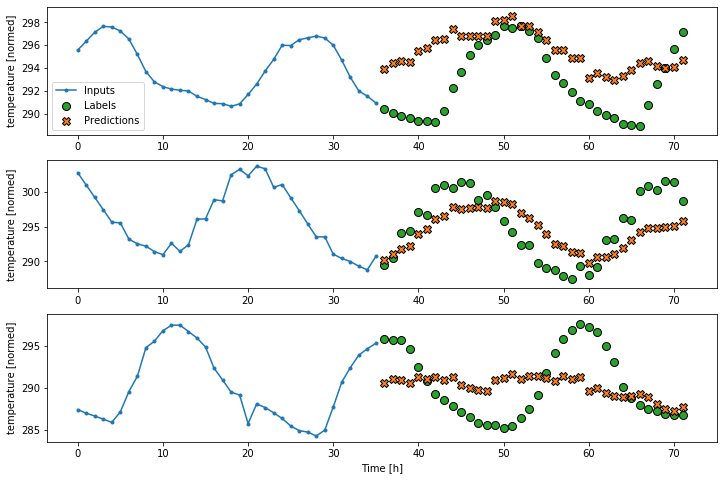

In [20]:
multi_window.plot(multi_dense_model, plot_col=RESPONSE_VAR)

In [23]:
multi_dense_model.predict()

TypeError: 'MapDataset' object is not subscriptable

In [44]:
multi_window

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

In [55]:

multi_window = WindowGenerator(input_width=gap_size,
                               label_width=gap_size,
                               shift=gap_size,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df)

x = multi_window.make_dataset(multi_window.test_df[:multi_window.total_window_size], batch_size=4)

print(x)
# for i in x:
#     print(i[1])
    
#     print(i[1].shape)

<MapDataset shapes: ((None, 36, 7), (None, 36, 7)), types: (tf.float32, tf.float32)>


In [24]:
multi_dense_model.predict(window.make_dataset(window.test_df[:window.total_window_size], batch_size=4)).shape

NameError: name 'window' is not defined

In [27]:
window.test_df[:window.input_width].shape

(36, 7)

#### Single Window

In [65]:
window = single_window

nan_index = 167

start_index = nan_index - window.input_width
window_instance = window.test_df[
                                start_index:
                                window.input_width + (start_index)]

window_instance = window.test_df[:window.input_width]
                                

In [68]:

# window_instance = window.make_dataset(window_instance)

linear.predict(window_instance)

# for el in window_instance.as_numpy_iterator():
#     print(el)

array([[288.26376],
       [287.6865 ],
       [288.3368 ],
       [288.2357 ],
       [288.7904 ],
       [288.7488 ],
       [289.49124]], dtype=float32)

In [69]:
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [53]:
def make_prediction_window(self, data, batch_size=32,):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.input_width,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_prediction_window = make_prediction_window


In [62]:
single_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [63]:
single_window.total_window_size

8

In [64]:
multi_window

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

In [115]:
multi_window

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

In [122]:
window_instance.shape

(36, 7)

In [120]:
window = multi_window

nan_index = 167

start_index = nan_index - window.input_width
# window_instance = window.test_df[
#                                 start_index:
#                                 window.input_width + (start_index)]

window_instance = window.test_df[:window.input_width]

# window_instance.shape

multi_dense_model.predict(window.make_dataset())

def make_dataset(self, data, batch_size=32,):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


# print(window_instance)
# window_instance = window.make_prediction_window(window_instance)

# multi_dense_model.predict(window_instance).shape

# for el in window_instance:
#     print(el)

ValueError: in user code:

    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:421 call
        inputs, training=training, mask=mask)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:919 call
        result = self.function(inputs, **kwargs)
    <ipython-input-14-04a673f72724>:17 <lambda>
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1051 _slice_helper
        name=name)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1223 strided_slice
        shrink_axis_mask=shrink_axis_mask)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:10537 strided_slice
        shrink_axis_mask=shrink_axis_mask, name=name)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3565 _create_op_internal
        op_def=op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /home/franticoreo/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node sequential/lambda/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=5, ellipsis_mask=0, end_mask=7, new_axis_mask=0, shrink_axis_mask=0](sequential/Cast, sequential/lambda/strided_slice/stack, sequential/lambda/strided_slice/stack_1, sequential/lambda/strided_slice/stack_2)' with input shapes: [?,7], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


### Why does the model need the total window size as input and not the input size

In [113]:
WindowGenerator(input_width=gap_size,
                               label_width=1,
                               shift=OUT_STEPS,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df)

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [71]
Label column name(s): None

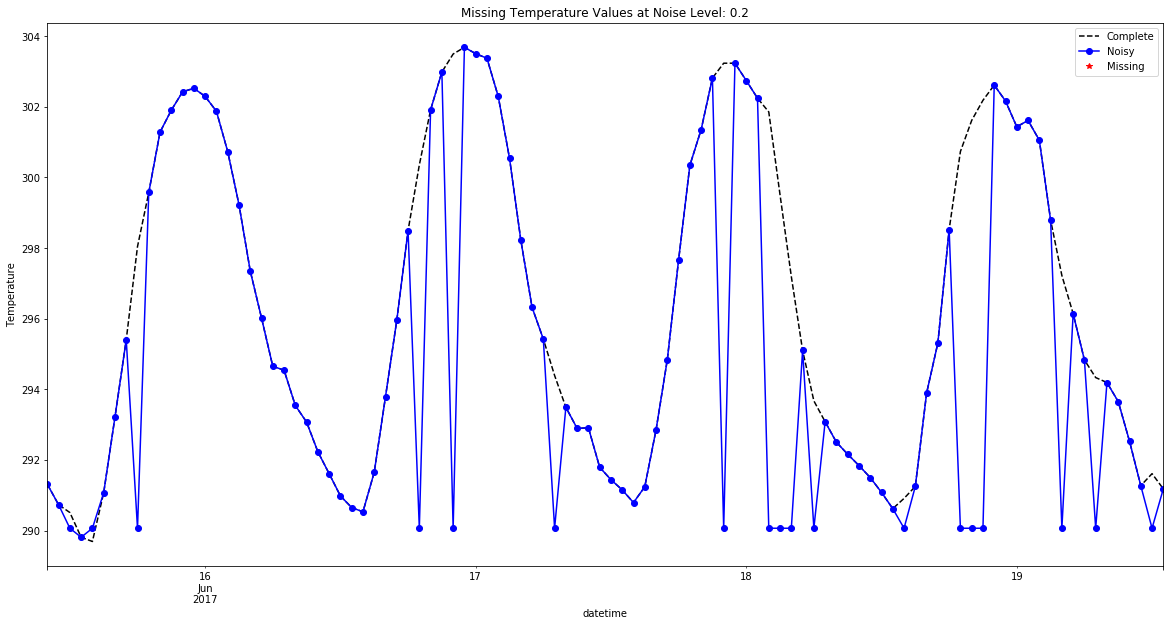

In [38]:
plot_noisy_series(test_df[RESPONSE_VAR], interp_textbook)